### Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

### Загрузка данных

In [2]:
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

### Просмотр данных

In [3]:
train

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
...,...,...,...,...
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0


In [4]:
train['values']

0        [-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....
1        [-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...
2        [0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...
3        [-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...
4        [1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...
                               ...                        
79995    [-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...
79996    [-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...
79997    [-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...
79998    [-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...
79999    [0.12, -0.8, 1.62, 0.11, -0.38, -0.86, -0.85, ...
Name: values, Length: 80000, dtype: object

### Визуализация 

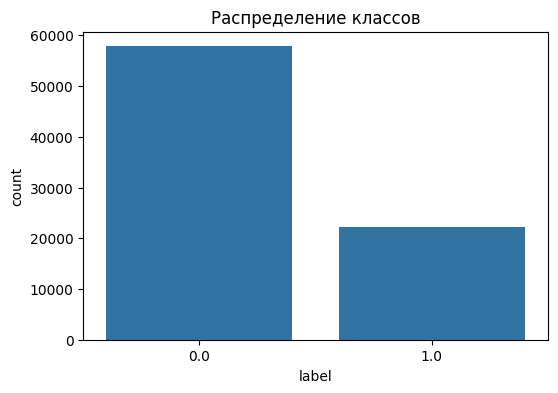

In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=train)
plt.title('Распределение классов')
plt.show()

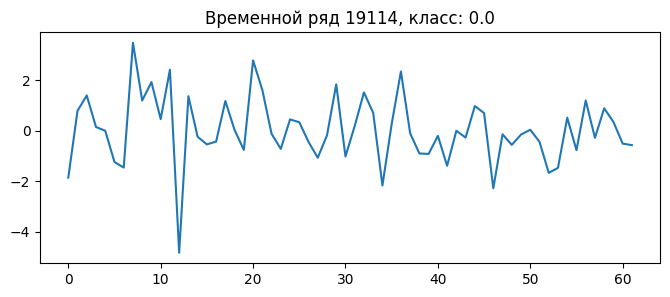

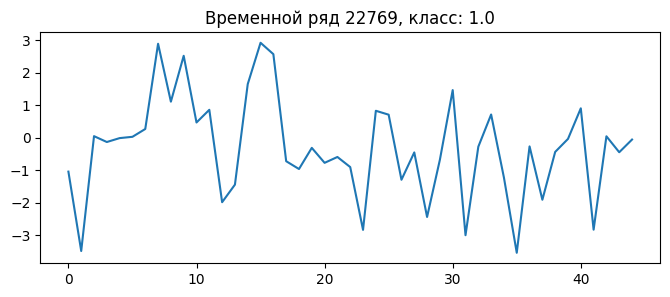

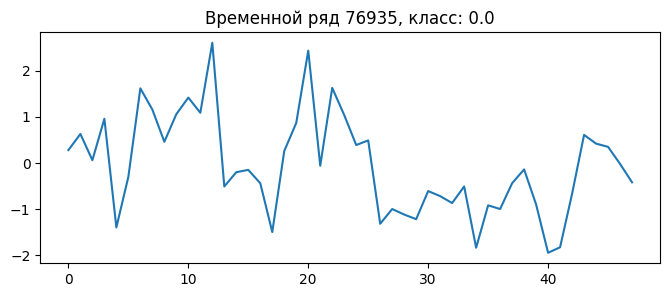

In [6]:
for i in range(3):
 plt.figure(figsize=(8, 3))
 plt.plot(train['values'][i])
 plt.title(f'Временной ряд {train["id"][i]}, класс: {train["label"][i]}')
 plt.show()

### Просмотр пропущенных значений

In [7]:
def percent_missing(df):
 total = 100 * df.isnull().sum() / len(df)
 total = total[total > 0].sort_values(ascending=False)
 return total

In [8]:
missing = percent_missing(train)
missing

Series([], dtype: float64)

In [9]:
missing = percent_missing(test)
missing

Series([], dtype: float64)

### Feature Engineering

In [10]:
def feat_engin(df):
    data = []
    for i in range(len(df)):
        values = np.log1p(np.abs(df['values'][i])) * np.sign(df['values'][i])
        dates = pd.to_datetime(df['dates'][i])
        
        features = {
            'id': df['id'][i],
            'mean': np.mean(values),
            'std': np.std(values),
            'min': np.min(values),
            'max': np.max(values),
            'median': np.median(values),
            'q25': np.quantile(values, 0.25),
            'q75': np.quantile(values, 0.75),
            'range': np.max(values) - np.min(values),
            'trend': np.polyfit(range(len(values)), values, 1)[0],
            'time_range': (dates.max() - dates.min()).days,
            'autocorr': pd.Series(values).autocorr(lag=1),
        }
        data.append(features)
    
    return pd.DataFrame(data)

In [11]:
train_f = feat_engin(train)

In [12]:
train_f

,id,mean,std,min,max,median,q25,q75,range,trend,time_range,autocorr
0,19114,0.005581,0.719671,-1.764731,1.501853,-0.104319,-0.519512,0.570785,3.266583,-0.007067,1858,-0.044080
1,22769,-0.169034,0.803012,-1.511695,1.366092,-0.242483,-0.712950,0.536493,2.877786,-0.013923,1340,0.226788
2,76935,-0.042716,0.655924,-1.081805,1.283708,-0.135395,-0.629917,0.479321,2.365513,-0.020517,1433,0.562239
3,66297,-0.077743,0.713705,-1.169381,1.249902,-0.296332,-0.667829,0.601569,2.419283,0.032148,1430,0.693152
4,2191,-0.172995,0.745635,-1.252763,1.353255,-0.387686,-0.810930,0.516910,2.606017,-0.006774,1674,0.041284
...,...,...,...,...,...,...,...,...,...,...,...,...
79995,71474,0.115141,0.715915,-1.534714,1.269761,0.148420,-0.307377,0.700099,2.804475,-0.000962,1643,0.127589
79996,36908,-0.073690,0.741693,-1.278152,1.150572,-0.165514,-0.751567,0.751416,2.428724,-0.007958,1584,0.448034
79997,63517,-0.113600,0.689385,-1.358409,1.184790,-0.131028,-0.644451,0.401986,2.543199,0.025091,1522,0.322219
79998,94731,-0.012239,0.837131,-1.348073,1.413423,0.215111,-0.898009,0.685590,2.761496,0.003855,1886,0.451358


### Визуализация

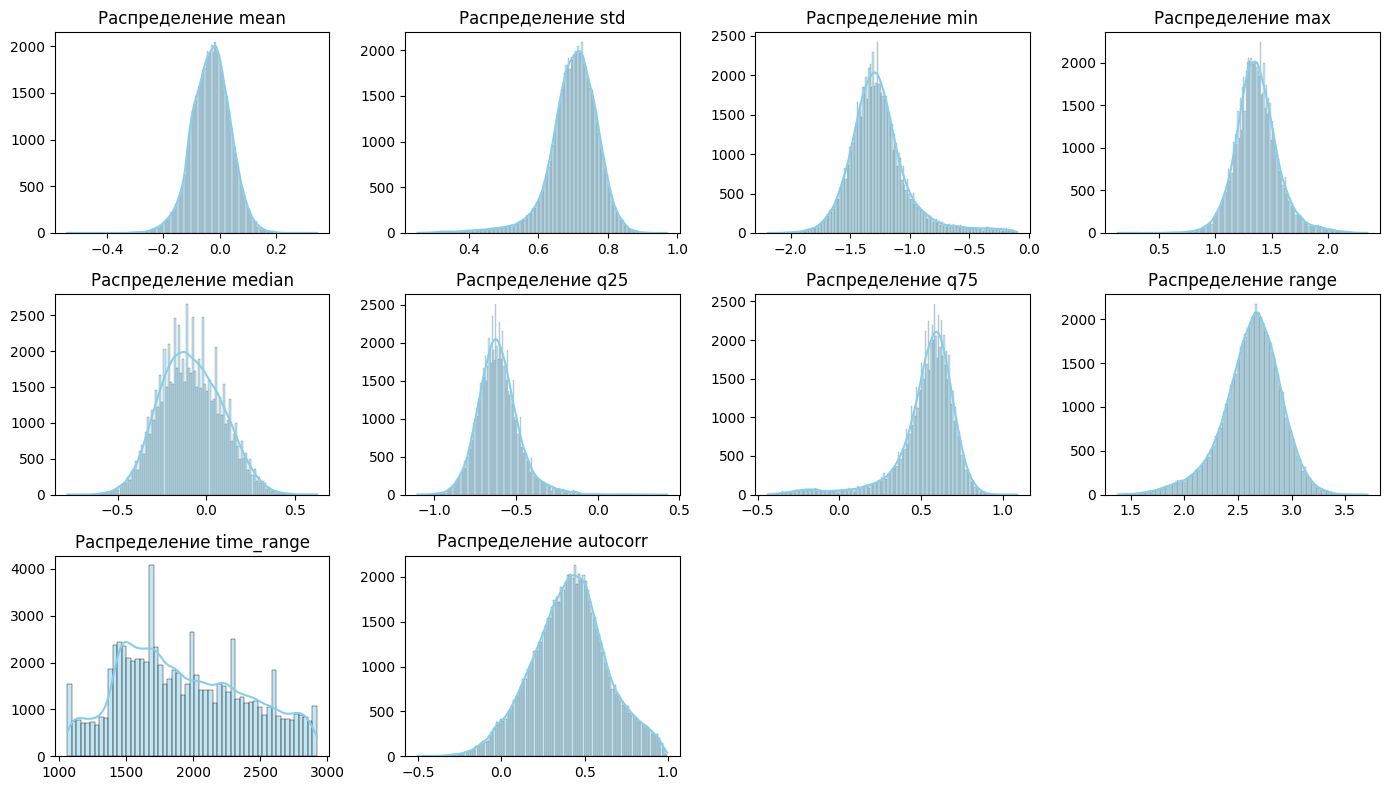

In [13]:
features_to_plot = ['mean', 'std', 'min', 'max', 'median', 'q25', 'q75', 'range', 'time_range', 'autocorr']
n_rows = 3
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))
for i, feature in enumerate(features_to_plot):
     row = i // n_cols
     col = i % n_cols
     sns.histplot(train_f[feature], kde=True, ax=axes[row, col], color='skyblue')
     axes[row, col].set_title(f'Распределение {feature}', fontsize=12)
     axes[row, col].set_xlabel('')
     axes[row, col].set_ylabel('')
    
for i in range(len(features_to_plot), n_rows * n_cols):
     fig.delaxes(axes.flatten()[i])
    
plt.tight_layout()
plt.show()

### Подготовка данных для обучения

In [14]:
X = train_f.drop('id', axis=1)
y = train['label']

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

### Обучение модели

#### Выбор XGBoost обусловлен его высокой эффективностью в задачах классификации гиперпараметры подобраны с помощью GridSearchCV в отдельном скрипте

In [16]:
model = xgb.XGBClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=6,
    subsample=1.0,
    colsample_bytree=0.8,
    gamma=0.5,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=1,
    tree_method='hist',
    device='cuda' # для ускорения обучения (nvidia rtx3050 8gb)
)

In [17]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

### Сохранение обученной модели

In [18]:
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### Предсказания на валидационной выборке и оценка качества

In [22]:
pred = model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, pred)

In [23]:
print("ROC AUC на валидации", (roc_auc))

ROC AUC на валидации 0.873491295771194


### Roc кривая

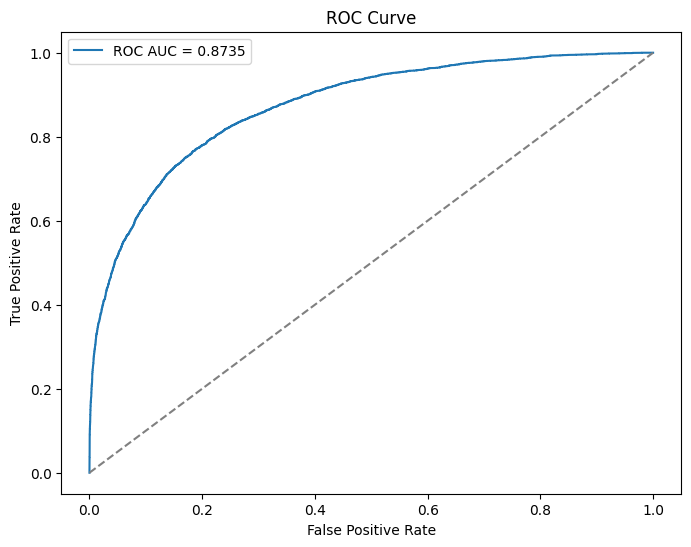

In [25]:
fpr, tpr, thresholds = roc_curve(y_val, pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()